<img src='../img/EU-Copernicus-EUM_3Logos.png' alt='Logo EU Copernicus EUMETSAT' align='right' width='50%'></img>

<br>

<a href="../00_index.ipynb"><< Index</a><br>
<a href="./325_air_pollution_map_europe_2020_Sentinel-5P_TROPOMI_NO2Tropo_L2.ipynb"><< 325 - Sentinel-5P TROPOMI anomaly map</a><span style="float:right;"><a href="./331_stratospheric_ozone_2019.ipynb
">331 - Stratospheric Ozone 2019 >></a></span>

<div class="alert alert-block alert-warning">
<b>30 - CASE STUDIES - AIR POLLUTION</b></div>

<div class="alert alert-block alert-warning">

<b>PREREQUISITES </b>

The following **20 - DATA DISCOVERY** modules are prerequisites:

- [241 - Sentinel-5P TROPOMI - Carbon Monoxide - Level 2 - Load and browse](../20_data_discovery/241_Sentinel-5P_TROPOMI_CO_L2_load_browse.ipynb) 
- [325 - Sentinel-5P TROPOMI anomaly map](../30_case_studies/325_air_pollution_map_europe_2020_Sentinel-5P_TROPOMI_NO2Tropo_L2.ipynb) 
    
    
It is recommended to go through these modules before you start with this module.
</div>

<hr>

# 3.2.6 Sentinel-5P TROPOMI Tropospheric NO<sub>2</sub> time-series analysis

This workflows will guide you through the different steps of how you can generate daily average time-series data of tropospheric NO<sub>2</sub> based on Copernius Sentinel-5P TROPOMI Level 2 data.

The aim is to have two time-series of `tropospheric NO2` for two periods and three different regions:
- **Time periods**:
 - December 2018 to 15 May 2019, and
 - December 2019 to 15 May 2020
- **Regions**:
 - Europe
 - Povalley (Italy)
 - Hubei (China)

### Data used
The workflow and analyses are based on the following data:
- Daily Sentinel-5P Level 2 files retrieved from the [Open Data Registry on AWS](https://registry.opendata.aws/sentinel5p/)

### Workflow outline
The workflow has the following outline:
- [Define a list with dictionaries holding bounding boxes for different regions](#region_list)
- [*Optional: Loop through the files of daily tropopsheric NO<sub>2</sub> and store the average values for each region as dictionary*](#optional_loop)
- [Open JSON file with daily average tropospheric NO<sub>2</sub> values for specific regions](#open_json)
- [Subset the time-series data and create 7-day and 15-day moving averages](#subset)
- [Visualize the Sentinel-5P TROPOMI NO<sub>2</sub> time-series data](#visualize)

#### Load required libraries

In [2]:
import glob
import os
import xarray as xr
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import json

#### Load helper functions

In [15]:
%run ../functions.ipynb

#### Function to help read and load .json files

In [4]:
def myconverter(o):
    if isinstance(o, datetime):
        return o.__str__()

<hr>

## <a id='region_list'></a>Define a list with dictionaries holding bounding boxes for different regions

You can define several regions as a dictionary, e.g. the bounding box information for Europe, the Po valley in Italy or the Hubei region in China. The dictionaries are stored in a list.

In [5]:
eur_extent={'name': 'eur_extent',
            'lonmin':-10.0,
            'lonmax':35,
            'latmin':35.0,
            'latmax':60.0}

# Italy (Po Valley, Milano)
povalley_extent={'name': 'povalley_extent',
                 'lonmin':7.0,
                'lonmax':13.0,
                'latmin':44.0,
                'latmax':47.0}


# China (Hubei, Wuhan)
hubei_extent={'name': 'hubei_extent',
              'lonmin':108.3,
              'lonmax':116.1,
              'latmin':29.1,
              'latmax':33.3}

region_list =[eur_extent,
             povalley_extent,
             hubei_extent]


## <a id='optional_loop'></a>*Optional: Loop through the files of daily tropopsheric NO<sub>2</sub> and store the average values for each region as dictionary*

This part of the workflow is optional. It opens daily Sentinel-5P Level 2 `Cloud-Optimised GeoTiff` files, creates the average NO<sub>2</sub> value of a geographical subset for a specified region and stores the daily mean value and datetime stamp in two lists. The two lists combined as a dictionary are returned by the function. 

The downloaded `COG` files are in the folder `/eodata/sentinel5p/no2/`. The time-series data have already been computed and stored as a `JSON` file in the directory `/eodata/sentinel5p/no2/json/`. Thus, you can skip this step and continue directly with the next [workflow step](#open_json).

#### List all files ending with `.tif` and store them in a list of files

In [4]:
fileList = glob.glob('../eodata/sentinel5p/no2/*.tif')
fileList_sort = sorted(fileList)

#### Function that loops over each region and each file and saves the daily average tropospheric NO<sub>2</sub> values as dictionary

For each region in the region list, the loop executes the following steps:
- Loop over each file in the file list
- Open the file as `xarray.DataArray()`
- Rename `x` and `y` to `longitude` and `latitude`
- Create a geographical subset with the function [generate_geographical_subset](../functions.ipynb#generate_geographical_subset) based on the region's bounding box
- Flag negative values
- Compute the spatial mean of the geographical subset
- Append the mean value to a list of mean values
- Do the same for the date time instance

For each region, the dictionary holds two lists, with datetime information and the average tropospheric NO<sub>2</sub> values for the respective day and region.


In [7]:
region_dict={}
# Loop through each region in the region list
for region in region_list:
    print(region)
    # Initiate an empty list for date and mean values
    date_list=[]
    mean_list=[]
    # Loop through each file in the file list
    for i in range(len(fileList)):
        print(i)
        # Open the tif file as xarray.DataArray with the function 'open_rasterio()'
        tmp = xr.open_rasterio(fileList[i])
        # Rename x and y to longitude and latitude in order to use the function 'generate_geographical_subset'
        tmp= tmp.rename({'x': 'longitude', 'y':'latitude'})
    
       # Create a geographical subset for the specific region
        tmp_sub = generate_geographical_subset(xarray=tmp,
                                               latmin=region['latmin'],
                                               latmax=region['latmax'],
                                               lonmin=region['lonmin'],
                                               lonmax=region['lonmax'])
        
        # Flag negative values
        tmp_sub_flag = tmp_sub.where(tmp_sub>0,np.nan)
        
        # Create the daily average tropospheric NO2 value for the specific region
        tmp_sub_mean = tmp_sub_flag.mean()

        # Add the mean value to the list
        mean_list.append((tmp_sub_mean.values).item())
        
        # Retrieve the date from the file name
        date = (fileList[i].split('_'))[8]
        # Create a datetime object and append it to the list of dates
        date_dt = datetime.strptime(date, '%Y%m%d')    
        date_list.append(date_dt)
    
    # Combine both lists in a dictionary
    region_dict[region['name']] = {'date':date_list,
                                    'mean':mean_list}

{'name': 'eur_extent', 'lonmin': -10.0, 'lonmax': 35, 'latmin': 35.0, 'latmax': 60.0}
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255


#### Save time-series dictionary as JSON file

Save the dictionary with daily average tropospheric NO<sub>2</sub> values for each region as `JSON` file. You can use the function `json.dump()` to store a dictionary as `JSON`.

In [11]:
with open('../region_dict.json', 'w') as f:
        json.dump(region_dict, f, default=myconverter)

<br>

## <a id='open_json'></a>Open `JSON` file with daily average tropospheric NO<sub>2</sub> values for specific regions 

Load the `JSON` file that contains a dictionary with three regions as keys and each key has two lists, one with daily `datetime` information and one with average tropospheric NO<sub>2</sub> values for each day for the specific region. You can load a `JSON` file with the function `json.load()`.

The `JSON` file is in the directory `/eodata/sentinel5p/no2/json/`.

In [6]:
with open("../eodata/sentinel5p/no2/json/region_dict.json",encoding='utf-8', errors='ignore') as json_data:
     data = json.load(json_data, strict=False)



## <a id='subset'></a>Subset the time-series data and create 7-day and 15-day moving averages 

For each region in the region list, you do the following:
- Load the dictionry with the region key as `pandas.DataFrame`
- Sort the `pandas.DataFrame` by `date`
- Create 7-day and 15-day moving averages
- Set the `date` column as index
- Subset the time-series for the years 2019 and 2020 with the pandas function `df_subset`
- Reformat the `datetime` index
- Merge the two time-series
- Store the values of the three aggregation values (`mean`, `7day_mean` and `15day_mean`) as keys in the dictionary

In [16]:
no2_1920_dict = {}
for region in region_list:
    print(region)
    # Open time-series information as pandas.DataFrame and sort the values based on date
    tmp_df = pd.DataFrame(data[region['name']])
    tmp_df = tmp_df.sort_values(by='date')

    # Create 7-day and 15-day rolling windows average values
    tmp_df['7day_mean'] = tmp_df.iloc[:,1].rolling(window=7, min_periods=3, center=False).mean()
    tmp_df['15day_mean'] = tmp_df.iloc[:,1].rolling(window=15, min_periods=3, center=False).mean()
    
    # Take the data columns and set it as index of the pandas.DataFrame
    tmp_df = tmp_df.set_index('date')
    
    #Create two subsets for 2019 and 2020
    tmp_df_2019, tmp_df_2020 = df_subset(tmp_df, '2018-11-30', '2019-05-15', '2019-11-30', '2020-05-15')

    # Reformat the timestamp of the datatime index
    tmp_df_2019.index = pd.DatetimeIndex(tmp_df_2019.index).strftime('%m-%d')
    tmp_df_2020.index = pd.DatetimeIndex(tmp_df_2020.index).strftime('%m-%d')
    
    #Merge time-series subsets together
    tmp_df_merged = tmp_df_2019.merge(tmp_df_2020, how='left', left_index=True, right_index=True)
    print(region)
    # Create a dictionary of the pandas.DataFrame
    no2_1920_dict[region['name']] = {
        'mean': {
            'date': tmp_df_merged.index,
            '2019': tmp_df_merged['mean_x'].to_list(),
            '2020': tmp_df_merged['mean_y'].to_list()},
        '7day_mean': {
            'date': tmp_df_merged.index,
            '2019': tmp_df_merged['7day_mean_x'].to_list(),
            '2020': tmp_df_merged['7day_mean_y'].to_list()},
        '15day_mean': {
            'date': tmp_df_merged.index,
            '2019': tmp_df_merged['15day_mean_x'].to_list(),
            '2020': tmp_df_merged['15day_mean_y'].to_list()}
    }                      

{'name': 'eur_extent', 'lonmin': -10.0, 'lonmax': 35, 'latmin': 35.0, 'latmax': 60.0}
{'name': 'eur_extent', 'lonmin': -10.0, 'lonmax': 35, 'latmin': 35.0, 'latmax': 60.0}
{'name': 'povalley_extent', 'lonmin': 7.0, 'lonmax': 13.0, 'latmin': 44.0, 'latmax': 47.0}
{'name': 'povalley_extent', 'lonmin': 7.0, 'lonmax': 13.0, 'latmin': 44.0, 'latmax': 47.0}
{'name': 'hubei_extent', 'lonmin': 108.3, 'lonmax': 116.1, 'latmin': 29.1, 'latmax': 33.3}
{'name': 'hubei_extent', 'lonmin': 108.3, 'lonmax': 116.1, 'latmin': 29.1, 'latmax': 33.3}


#### Optional: store the dictionary as `JSON` file

Save the dictionary of the temporal subset for values as `JSON`. You can use again the function `json.dump()` to store the content of a dictionary as `JSON`. This step is optional, as the `JSON` has already been stored and is available in the directory `/eodata/sentinel5p/no2/json/`.

In [38]:
with open('./s5p_ts_2019_2020_till_may.json', 'w') as f:
        json.dump(no2_1920_dict, f, default=myconverter)

<br>

## <a id='visualize'></a>Visualize the Sentinel-5p TROPOMI NO<sub>2</sub> time-series data

The last step is to visualize the time-series for 2019 and 2020 together in one plot. This helps to compare the difference of tropopsheric NO<sub>2</sub> between both years.

For each region, plot the two time-series data (2019 and 2020) of daily tropospheric NO<sub>2</sub> data for six months (December to mid May).

You can loop over the different regions in the dictionary, select the list of interest and load it as `pandas.DataFrame`. The function `plot.line()` allows to plot two different columns based on the same datetime index.

The grey line corresponds to daily tropospheric NO<sub>2</sub> data in 2019 and the darkred line to values of 2020 accordingly.


#### Define conversion factor for Sentinel-5P data

Let us define again the conversion factor for Sentinel-5P data to convert the NO<sub>2</sub> from `mol per m`<sup>`2`</sup> to `molecules per cm`<sup>`2`</sup> and apply it to the data to be plotted.

In [17]:
conversion_factor=6.02214*1e+19

### Visualize the daily `mean` values of tropospheric NO<sub>2</sub>

As dictionary key, you select `['mean']` and you apply the `plot.line()` function of the pandas library, which easily allow to do a line plot of a pandas.DataFrame.

eur_extent


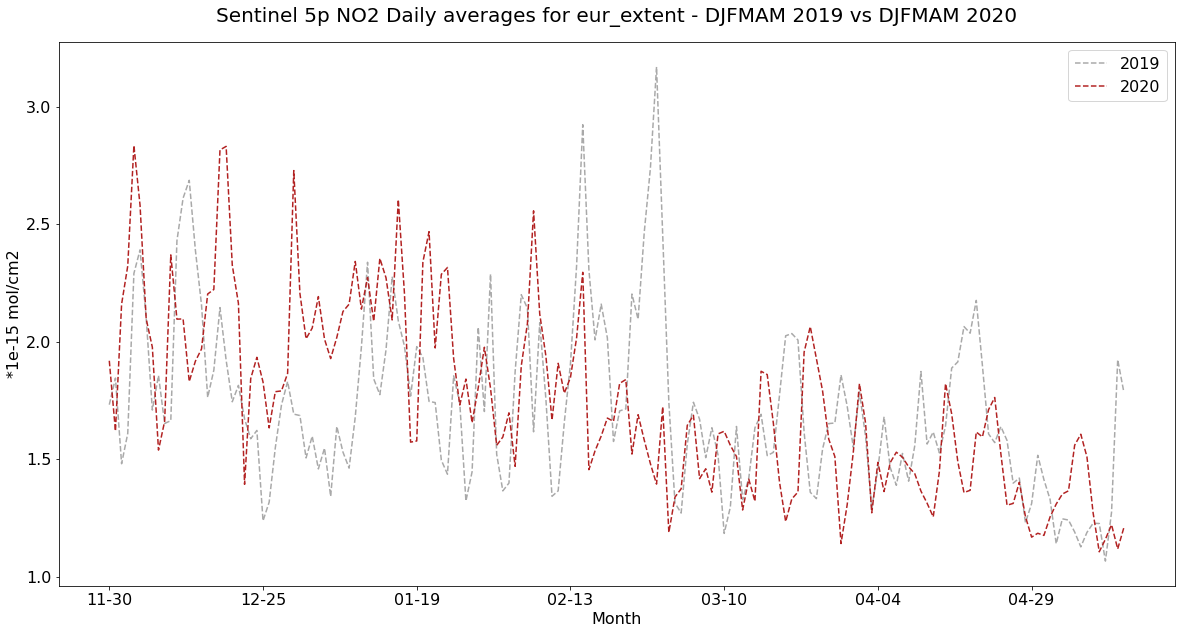

povalley_extent


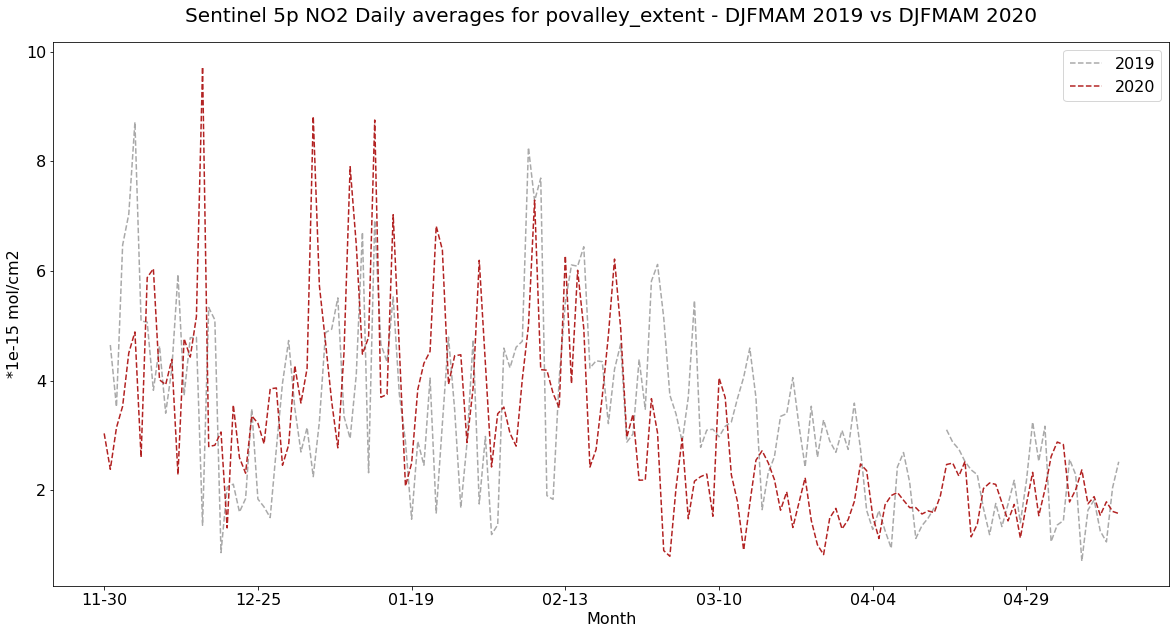

hubei_extent


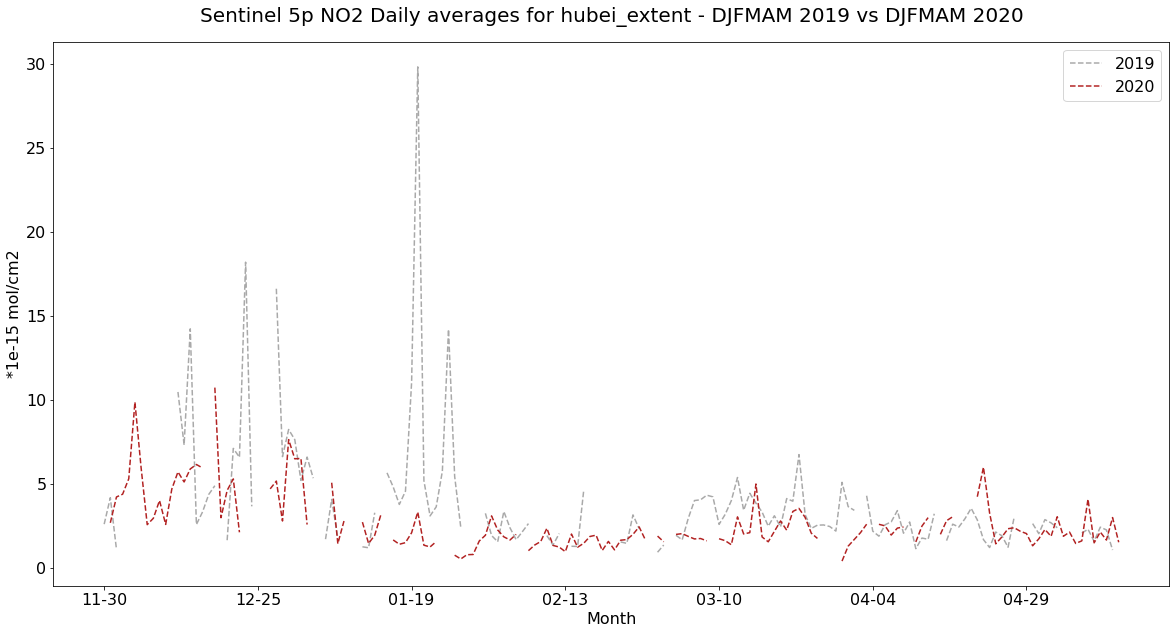

In [18]:
for region in no2_1920_dict.keys():
    print(region)
    djfm_mean = pd.DataFrame(no2_1920_dict[region]['mean'])
    djfm_mean = djfm_mean.set_index('date')

    ax=(djfm_mean*conversion_factor*1e-15).plot.line(figsize=(20,10), linestyle='dashed',color=['darkgrey','firebrick'],label=['DJFM 2019','DJFM 2020'])

    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.title("Sentinel 5p NO2 Daily averages for " + region +  " - DJFMAM 2019 vs DJFMAM 2020", fontsize=20, pad=20)
    plt.ylabel('*1e-15 mol/cm2', fontsize=16)
    plt.xlabel('Month', fontsize=16)
    plt.legend(fontsize=16,loc=1)
    plt.show()

### Visualize the daily `7-day mean` values of tropospheric NO<sub>2</sub>

As dictionary key, you select `['7day_mean']`.

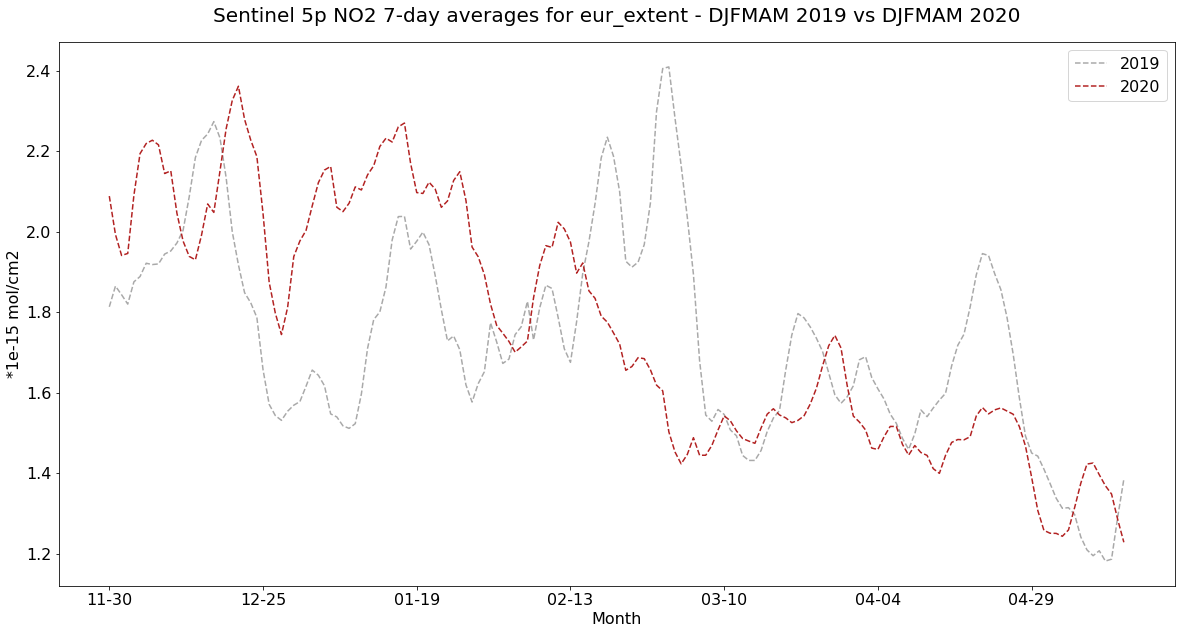

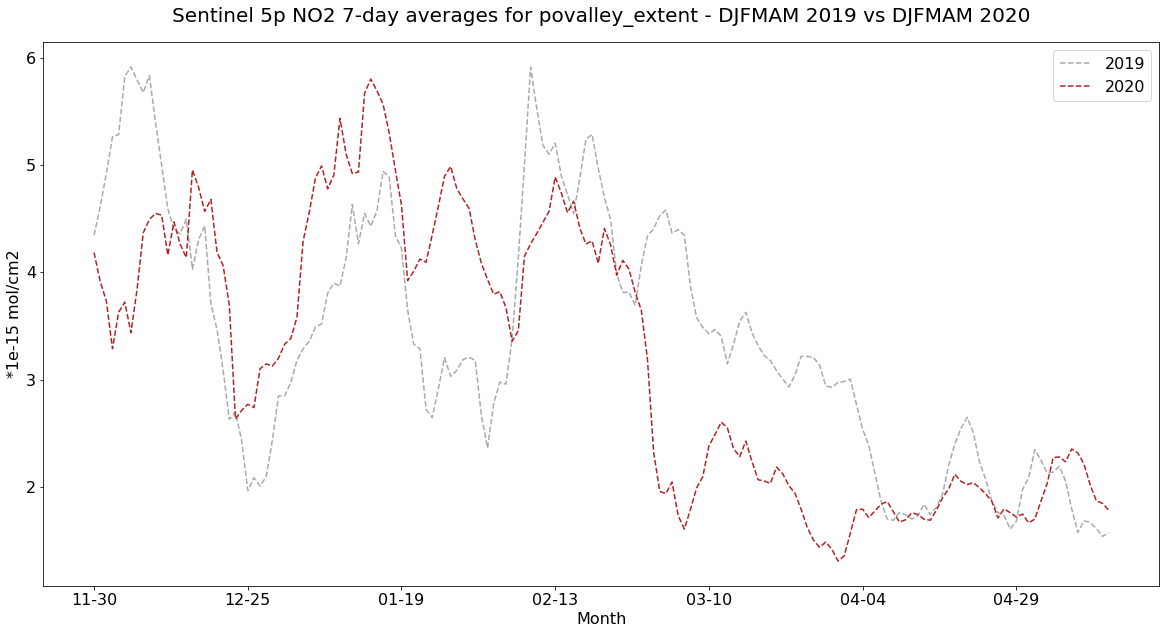

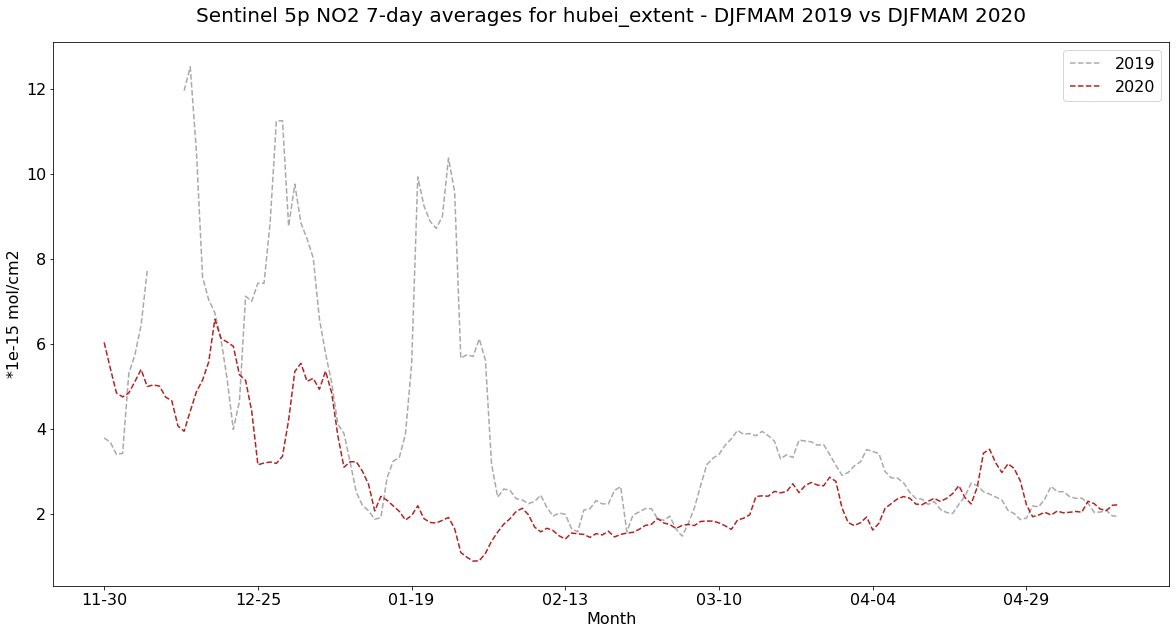

In [19]:
for region in no2_1920_dict.keys():
    djfm_mean = pd.DataFrame(no2_1920_dict[region]['7day_mean'])
    djfm_mean = djfm_mean.set_index('date')

    (djfm_mean*conversion_factor*1e-15).plot.line(figsize=(20,10), linestyle='dashed',color=['darkgrey','firebrick'],label=['DJFM 2019','DJFM 2020'])

    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.title("Sentinel 5p NO2 7-day averages for " + region +  " - DJFMAM 2019 vs DJFMAM 2020", fontsize=20, pad=20)
    plt.ylabel('*1e-15 mol/cm2', fontsize=16)
    plt.xlabel('Month', fontsize=16)
    plt.legend(fontsize=16,loc=1)
    plt.show()

### Visualize the daily `15-day mean` values of tropospheric NO<sub>2</sub>

As dictionary key, you select `['15day_mean']`.

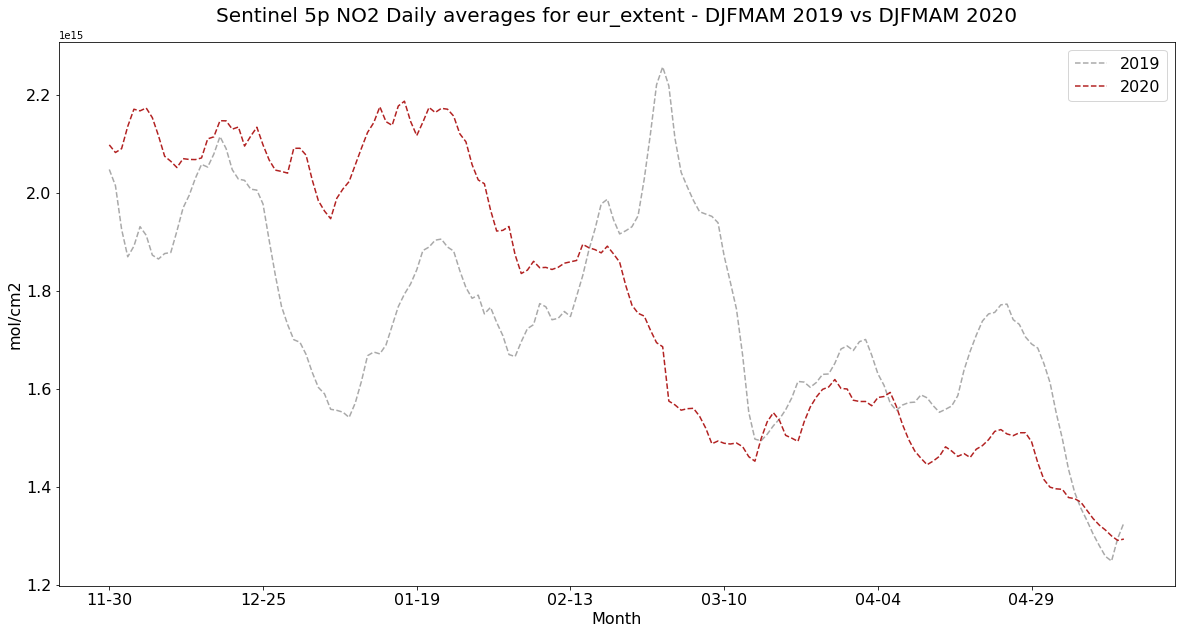

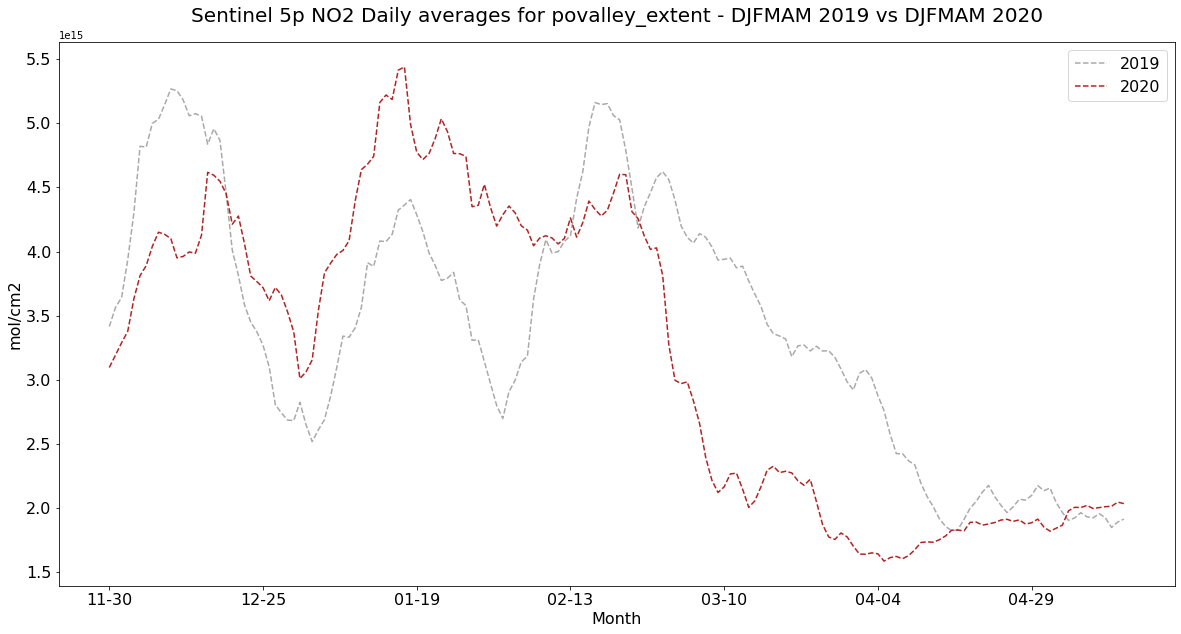

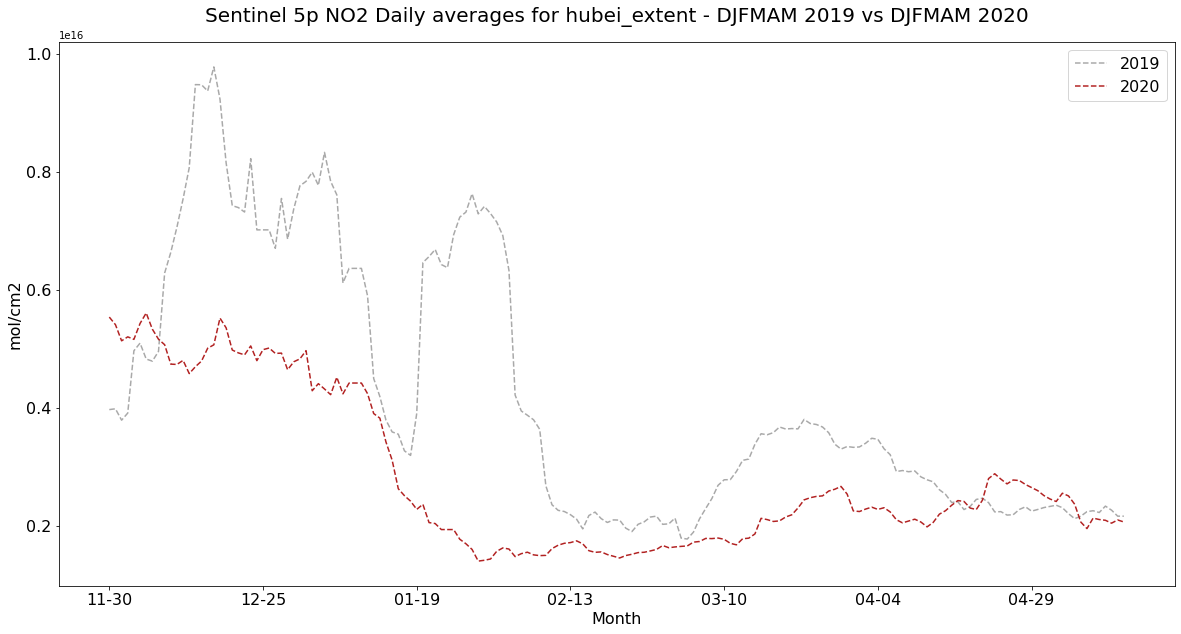

In [20]:
for region in no2_1920_dict.keys():
    djfm_mean = pd.DataFrame(no2_1920_dict[region]['15day_mean'])
    djfm_mean = djfm_mean.set_index('date')

    (djfm_mean*conversion_factor).plot.line(figsize=(20,10), linestyle='dashed',color=['darkgrey','firebrick'],label=['DJFM 2019','DJFM 2020'])

    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.title("Sentinel 5p NO2 Daily averages for " + region +  " - DJFMAM 2019 vs DJFMAM 2020", fontsize=20, pad=20)
    plt.ylabel('mol/cm2', fontsize=16)
    plt.xlabel('Month', fontsize=16)
    plt.legend(fontsize=16,loc=1)
    plt.show()

<br>

<a href="../00_index.ipynb"><< Index</a><br>
<a href="./325_air_pollution_map_europe_2020_Sentinel-5P_TROPOMI_NO2Tropo_L2.ipynb"><< 325 - Sentinel-5P TROPOMI anomaly map</a><span style="float:right;"><a href="./331_stratospheric_ozone_2019.ipynb
">331 - Stratospheric Ozone 2019 >></a></span>

<hr>

<p><img src='../img/copernicus_logo.png' align='left' alt='Logo EU Copernicus' width='25%'></img></p>
<br clear=left>
<p style="text-align:left;">This project is licensed under the <a href="../LICENSE">MIT License</a> <span style="float:right;"><a href="https://gitlab.eumetsat.int/eumetlab/atmosphere/atmosphere">View on GitLab</a> | <a href="https://training.eumetsat.int/">EUMETSAT Training</a>